# 1) Importing Libraries and Dataset

We begin our EDA by importing the necessary libraries and loading the dataset `TWO_CENTURIES_OF_UM_RACES.csv`. This Dataset contains ultramarathon race results, including event details, athlete information, and performance metrics.

In [2]:
import pandas as pd
import seaborn as sns

df = pd.read_csv('../datasets/TWO_CENTURIES_OF_UM_RACES.csv')
original_df = df.copy()
df.head()

C:\Users\gamin\AppData\Local\Temp\ipykernel_17512\1300914617.py:4: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../datasets/TWO_CENTURIES_OF_UM_RACES.csv')


,Year of event,Event dates,Event name,Event distance/length,Event number of finishers,Athlete performance,Athlete club,Athlete country,Athlete year of birth,Athlete gender,Athlete age category,Athlete average speed,Athlete ID
0,2018,06.01.2018,Selva Costera (CHI),50km,22,4:51:39 h,Tnfrc,CHI,1978.0,M,M35,10.286,0
1,2018,06.01.2018,Selva Costera (CHI),50km,22,5:15:45 h,Roberto Echeverría,CHI,1981.0,M,M35,9.501,1
2,2018,06.01.2018,Selva Costera (CHI),50km,22,5:16:44 h,Puro Trail Osorno,CHI,1987.0,M,M23,9.472,2
3,2018,06.01.2018,Selva Costera (CHI),50km,22,5:34:13 h,Columbia,ARG,1976.0,M,M40,8.976,3
4,2018,06.01.2018,Selva Costera (CHI),50km,22,5:54:14 h,Baguales Trail,CHI,1992.0,M,M23,8.469,4


## 2) Data Cleaning

**Cleaning Steps:**
1. Filter for 50mi/50km races, year 2020, USA only  
2. Handle missing values 
3. Remove unnecessary columns/rows  
4. Correct Strings and data types  
5. Create new calculated columns  


### 2.1 Filtering for Relevant Races

We select only 50mi/50km races from 2020 held in the USA to focus our analysis.

In [3]:
#Filter for 50mi and 50k
df = df[(df['Event distance/length'] == '50mi') | (df['Event distance/length'] == '50km')]

In [4]:
#Filter for 2020
df = df[df['Year of event'] == 2020]

In [5]:
#Filter for USA
df[['Event name', 'Event Country']] = df['Event name'].str.split('(', n=1, expand=True)
df['Event Country'] = df['Event Country'].str.replace(')', '')
df = df[df['Event Country'] == 'USA']
df.shape

(26090, 14)

### 2.2 Handling Nulls

To prepare the dataset for analysis, we first checked for missing values and dropped any fully empty rows. For columns that I know I will need for analysis (in this case, Athlete year of birth), we filled missing values with the average value instead of dropping them. This approach keeps the data usable while minimizing information loss.


In [6]:
#Search for Nulls
nulls = df.isna().sum()
nulls

Year of event                   0
Event dates                     0
Event name                      0
Event distance/length           0
Event number of finishers       0
Athlete performance             0
Athlete club                 3119
Athlete country                 0
Athlete year of birth         233
Athlete gender                  0
Athlete age category          217
Athlete average speed           0
Athlete ID                      0
Event Country                   0
dtype: int64

In [7]:
#drop rows where all elements are NaN as these are empty rows
df = df.dropna(how = 'all')

#filling the Athlete year of birth with the mean as I need this column to calculate age
df = df.fillna({'Athlete year of birth': df['Athlete year of birth'].mean()})

df.isna().sum()

Year of event                   0
Event dates                     0
Event name                      0
Event distance/length           0
Event number of finishers       0
Athlete performance             0
Athlete club                 3119
Athlete country                 0
Athlete year of birth           0
Athlete gender                  0
Athlete age category          217
Athlete average speed           0
Athlete ID                      0
Event Country                   0
dtype: int64

### 2.3 Removing Unessarary Rows and Columns

To ensure data quality, we remove duplicate entries. We also drop columns that are irrelevant for our analysis or contain excessive missing values, simplifying the dataset for more effective exploration.

In [8]:
#drops rows with the exact same values in all columns
df = df.drop_duplicates()

#drop specific columns that I feel are not helpful, or have too many NaN values
df = df.drop(columns=['Athlete club', 'Athlete country', 'Athlete age category'])

#reset dataframe indices after dropping rows
df = df.reset_index(drop=True) 

### 2.4 Calculating new columns

We calculated each athlete's age at a given event by subtracting the 'Athlete year of birth' from the 'Year of event'. Adding this column provides valuable information for further analysis and visualization for age-related trends.


In [9]:
#Calculate Athlete Age
df['Athlete Age'] = df['Year of event'] - df['Athlete year of birth']

### 2.5 Cleaning strings and data types

In this step, we standardize string formats and convert columns to appropriate data types. This ensures consistency and enables accurate calculations and analysis in the following steps.

In [10]:
#Making sure there are no inconsistent strings (e.x some entries say 'M' while others say 'Male')
df['Athlete gender'].unique()

array(['M', 'F'], dtype=object)

In [11]:
#Remove 'h' from athlete performance strings as it is redundant
df['Athlete performance'] = df['Athlete performance'].str.replace(' h', '')

In [12]:
#Change important numeric columns to correct data types so that I can perform calculations
df['Athlete average speed'] = df['Athlete average speed'].astype(float)
df['Athlete Age'] = df['Athlete Age'].astype(int)

df.dtypes

Year of event                  int64
Event dates                   object
Event name                    object
Event distance/length         object
Event number of finishers      int64
Athlete performance           object
Athlete year of birth        float64
Athlete gender                object
Athlete average speed        float64
Athlete ID                     int64
Event Country                 object
Athlete Age                    int64
dtype: object

## 3) Data Visualization and Analysis

When approaching this part of the EDA process, set clear objectives for what questions you want your dataset to answer. Be curious. In my case, I want to answer two questions:

1. How much faster/slower were Males than Females in these Ultramarathons?
2. What age groups were the fastest?

**1.1 Visualizing gender and speed**

<Axes: xlabel='Athlete average speed', ylabel='Count'>

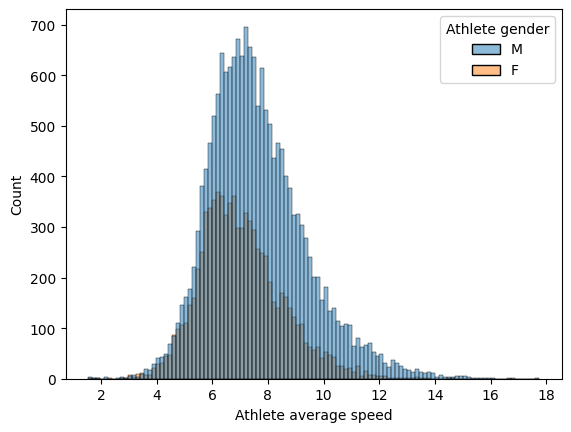

In [13]:
sns.histplot(df, x = 'Athlete average speed', hue = 'Athlete gender')

We see that the average athlete speed is higher for males (the peak of the histogram is further to the right). It's also important to note, however, that there are a lot more males in this dataset than there are females.

<Axes: xlabel='Athlete gender', ylabel='Athlete average speed'>

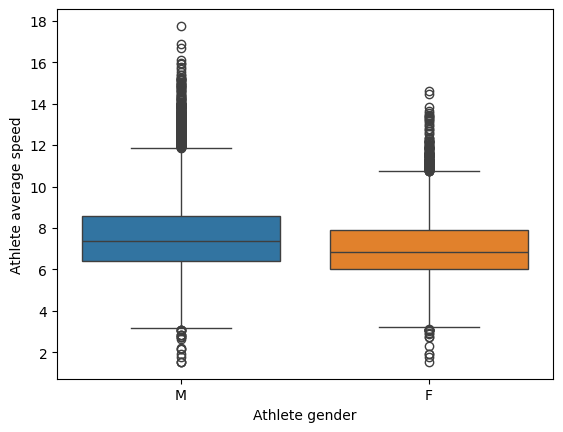

In [14]:
sns.boxplot(df, x = 'Athlete gender', y ='Athlete average speed', hue = 'Athlete gender')

This box plot shows us that there are MANY outliers for our dataset. We are goign to remove these outliers before making any calculations/comparisions with this data

In [15]:
Q1 = df['Athlete average speed'].quantile(0.25)
Q3 = df['Athlete average speed'].quantile(0.75)
IQR = Q3 - Q1

print(f'IQR: {IQR}')
print(f'Datapoints before removing outliers: {df.shape[0]}')

IQR: 2.1369999999999996
Datapoints before removing outliers: 26090


In [16]:
# Remove outliers that are outside the upper and lower extremes of the IQR
df = df[(df['Athlete average speed'] >= (Q1 - 1.5 * IQR)) & (df['Athlete average speed'] <= (Q3 + 1.5 * IQR))]
print(f'Datapoints after removing outliers: {df.shape[0]}')

Datapoints after removing outliers: 25490


After visualizing the spread of the average speeds and removing outliers, we can jump into calculating the mean speeds of both males and females.

In [17]:
#Make a df of just male entries
males = df[df['Athlete gender'] == 'M']
males = males[['Athlete gender', 'Athlete average speed']]
males['Athlete average speed'].astype(float)

#Calculate the average male speed
avgSpeedM = males['Athlete average speed'].mean()
males
print(avgSpeedM)

7.476763190112516


In [18]:
#Make a df of just female entries
females = df[df['Athlete gender'] == 'F']
females = females[['Athlete gender', 'Athlete average speed']]
females['Athlete average speed'].astype(float)

#Calculate the average male speed
avgSpeedF = females['Athlete average speed'].mean()
females
print(avgSpeedF)

7.006195513973852


In [19]:
#This is how much faster males are than females for the specific Ultramarathon events we filtered for
print(f'Males were {100* (avgSpeedM-avgSpeedF)/avgSpeedM}% faster')

Males were 6.2937351922681755% faster


SIDENOTE: I realized there is a much more efficient way of finding those averages above. 

The .groupby() command can be used to group multiple categories (in this case, Athlete genders), and compute different statistics on them individually (in this case, the mean of the athlete average speed column).

In [20]:
group = df.groupby('Athlete gender')
groupAVGSpeed = group["Athlete average speed"].mean()

groupAVGSpeed

Athlete gender
F    7.006196
M    7.476763
Name: Athlete average speed, dtype: float64

With this function, you can group by multiple categories too:

In [21]:
groupDistance = df.groupby(['Event distance/length', 'Athlete gender'])
groupDistance['Athlete average speed'].mean()

Event distance/length  Athlete gender
50km                   F                 7.051054
                       M                 7.570902
50mi                   F                 6.814056
                       M                 7.168017
Name: Athlete average speed, dtype: float64

**1.2 Visualizing age and speed**

<Axes: xlabel='Athlete Age', ylabel='Count'>

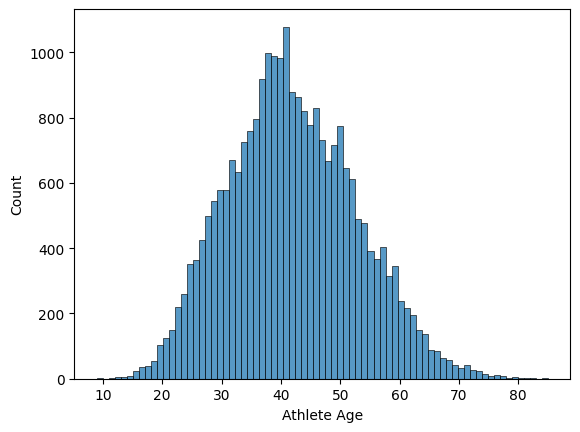

In [22]:
sns.histplot(df, x = 'Athlete Age')

This just shows us the average age of people who run these marathons. This isn't integral to the problem that we're trying to solve, but its still good to know. Let's move on to calculating the mean speeds by age group.

In [23]:
#First drop entries for people below 20 races as these could be outliers
x = df.groupby('Athlete Age').size()
df["Race Count"] = df["Athlete Age"].map(x)
dfx = df[df["Race Count"] > 19]

<Axes: xlabel='age', ylabel='speed'>

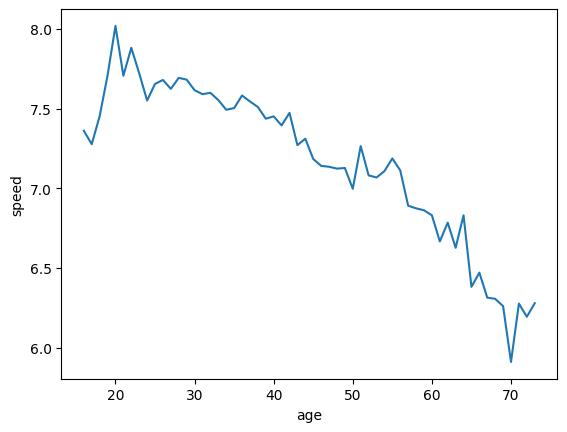

In [24]:
#Groups Athlete Age by mean speeds
seriesx = dfx.groupby('Athlete Age')['Athlete average speed'].mean()

#Sorts age froups from fastest to slowest
Sorted = seriesx.sort_values(ascending=False)

#Plots the average speed of each age group on a line plot to see how drastically the speed changes with age
dataframex = seriesx.reset_index()
dataframex.columns = ['age', 'speed']
sns.lineplot(dataframex, x = 'age', y='speed')

This trend is expected: as age increases, average ultramarathon speed decreases. Interestingly, runners under 25 are slower on average than those aged 25–30. This may be due to fewer data points for the younger group.

## The End!